### Things that need to be done

* Trim the top of the bearing data plot (doesn't make a lot of sense but sure)
* 
### Options for formattig data
* Use a JSON for a quickoverview of the survey metadata
* Use a csv format to store information about each of the drops

In [ ]:
# Library installs
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
DEBUG = False

In [ ]:
# Local loads
from lib.data_classes.pffpFolder import pffpDataFolder
from lib.mechanics_functions.relative_density_funcs import calc_Jamiolkowski_relative_density
from lib.mechanics_functions.general_geotech_funcs import ( calc_cambridge_mean_eff_stress, calc_consolidation_coeff, calc_mohr_coulomb_su, 
                                                            calc_dimensionless_velocity, calc_white_failure_mean_eff_stress
                                                          )
from lib.mechanics_functions.white_bearing_capacity import ( calc_qNet_dyn_at_vel, calc_qNet_undrained, calc_white_qNet_dyn, find_qNet_dry,
                                                             find_qNet_dry_2
)


### Calculating the White et al. (2018) values

In [ ]:
depth = 2

# generate some dimensionless velocities
dimensionless_vel = np.linspace(0.01, 100, 10000)

# Generate some drained tip resistances
qNet_ds = np.linspace(1400, 10000, 10)

# Calc the relative density
rel_density = calc_Jamiolkowski_relative_density(qNet_ds, depth)

# Calc the failure mean eff stress
p_f = calc_white_failure_mean_eff_stress(rel_density)

# Calc Su
su = calc_mohr_coulomb_su(p_f)

# Calc the qNet_undrained
qNet_ud = calc_qNet_undrained(su)

for qNet_ud, qNet_d in zip(qNet_ud, qNet_ds):

    qNet_dyn = calc_white_qNet_dyn(qNet_ud, qNet_d, dimensionless_vel)
    plt.loglog(dimensionless_vel, qNet_dyn)

# Format the plot
plt.xlabel("Dimensionless penetration velocity, $V = vD/c_{h}$")
plt.ylabel("Tip resistance $q_{net}$ (kPa)")
plt.title("Figure 3 of White et al. (2018)")
plt.show()

#### Stuff that can be calculated from White et al. Correlations

* qCPT = qCPT(relative density, k0, coeff_consolidation)
* coeff_consolidation = coeff_consolidation(relative_density)

#### Process for using the white et al. (2018)

1) Use Ali's or Duncan's correlation for relative density
2) Use the relative density to calc the "backbone curve" 
3) Use the value of the qNet_dyn (Use the force balance for this) to get the strength at the CPT speed. Do this for each depth in the penetration

In [ ]:
# Calc the relative density

qNet_d_guess = 10000

qNet_dyn = 1388.53552791
depth = 2
dimensionless_vel = 0.01

# Use the iterator to solve the for the net dry bearing resistance
qNet_dyn_solve = fsolve(find_qNet_dry, qNet_d_guess, args = (qNet_dyn, depth, dimensionless_vel))
print("Net dry bearing resistance", qNet_dyn_solve)

### Using the fir

In [ ]:
depth = 2

# generate some dimensionless velocities
dimensionless_vel = np.linspace(0.01, 100, 10000)

# Select a dry strength
qNet_d = 10000

# Calc the relative density
rel_density = calc_Jamiolkowski_relative_density(qNet_d, depth)

# Calc the failure mean eff stress
p_f = calc_white_failure_mean_eff_stress(rel_density)

# Calc Su
su = calc_mohr_coulomb_su(p_f)

# Calc the qNet_undrained
qNet_ud = calc_qNet_undrained(su)

qNet_dyn = calc_white_qNet_dyn(qNet_ud, qNet_d, dimensionless_vel)

print("Selected dry bearin resistance: ", qNet_d)
print("Undrained bearing resitance: ",qNet_ud)
print("First 10 Dynamic bearin resitances: ", qNet_dyn[:10])

In [ ]:
index = 0
qNet_dyn_check =3117.2790216
dimensionless_vel_2 = 0.01

qNet_d_guess = 1000

relative_density = rel_density
V_50 =1.0
Q = 10

depth = 2

qNet_dry = fsolve(find_qNet_dry, qNet_d_guess, args = (qNet_dyn_check, relative_density, dimensionless_vel_2, V_50, Q))
qNet_dry_rel = fsolve(find_qNet_dry_2, qNet_d_guess, args = (qNet_dyn_check, depth, dimensionless_vel_2, V_50, Q))
print(qNet_dry)
print(qNet_dry_rel)

In [ ]:
# Select the data index
index = 0

depth = 2

# Use the values from the previous cell as test data
qNet_dyn_check = qNet_dyn[index]
dimensionless_vel_check = dimensionless_vel[index]

qNet_d_guess = 1000

relative_density = rel_density
V_50 =1.0
Q = 10

depth = 2

# qNet_dry = fsolve(find_qNet_dry, qNet_d_guess, args = (qNet_dyn_check, relative_density, dimensionless_vel_2, V_50, Q))
qNet_dry_rel = fsolve(find_qNet_dry_2, qNet_d_guess, 
                      args = (qNet_dyn_check, depth, dimensionless_vel_check, V_50, Q))
# print(qNet_dry)
print(qNet_dry_rel)

I tried to include the relative density inside of the iterations so that you would only need to have the consolidation coefficient but there are two many solutions when a reasonable value for the consolidation coefficient is used.

In [ ]:
# Select the data index
index = 0

depth = 2

# Use the values from the previous cell as test data
qNet_dyn_check = qNet_dyn[index]
dimensionless_vel_check = dimensionless_vel[index]

# 1000 seems to be a stable guess for the range of values that I tested. If the iteration of the fsolve isn't stable 
# then the function can converge to a wacky number 
qNet_d_guess = 1000
diameter = 0.1

# Use the consolidation coefficient from White et al. (2018)
coeff_consolidation = 1e6/ (365 * 24 * 3600) 
measured_velocity = dimensionless_vel_check * coeff_consolidation/diameter

# Select the CPT velocity (Could be other velocity but CPT is the most common)
wanted_velocity = 0.02

# Get the qNet_dyn at the wanted velocity
wanted_qNet_dyn = calc_qNet_dyn_at_vel(qNet_d_guess, qNet_dyn_check, depth, rel_density, measured_velocity, coeff_consolidation, 
                                       wanted_velocity=wanted_velocity, probe_diameter=diameter, calc_relative_density=True)

# Calc this for later check
wanted_V = calc_dimensionless_velocity(wanted_velocity, diameter, coeff_consolidation)

# Plot the last calculated backbone curve
plt.loglog(dimensionless_vel, qNet_dyn, label = "Backbone curve")

# PLot the wanted values, there intersection should be on the backbone curve
plt.axhline(y = wanted_qNet_dyn, color = "green", linestyle = "dashed", label = "wanted qNet_dyn")
plt.axvline(x = wanted_V, color = "red", linestyle= "dashed", label = "wanted dimensionless V")
plt.legend()
plt.show()

#### Flow chart from Jaber (2023) DOI 10.1061/JGGEFK.GTENG-11013
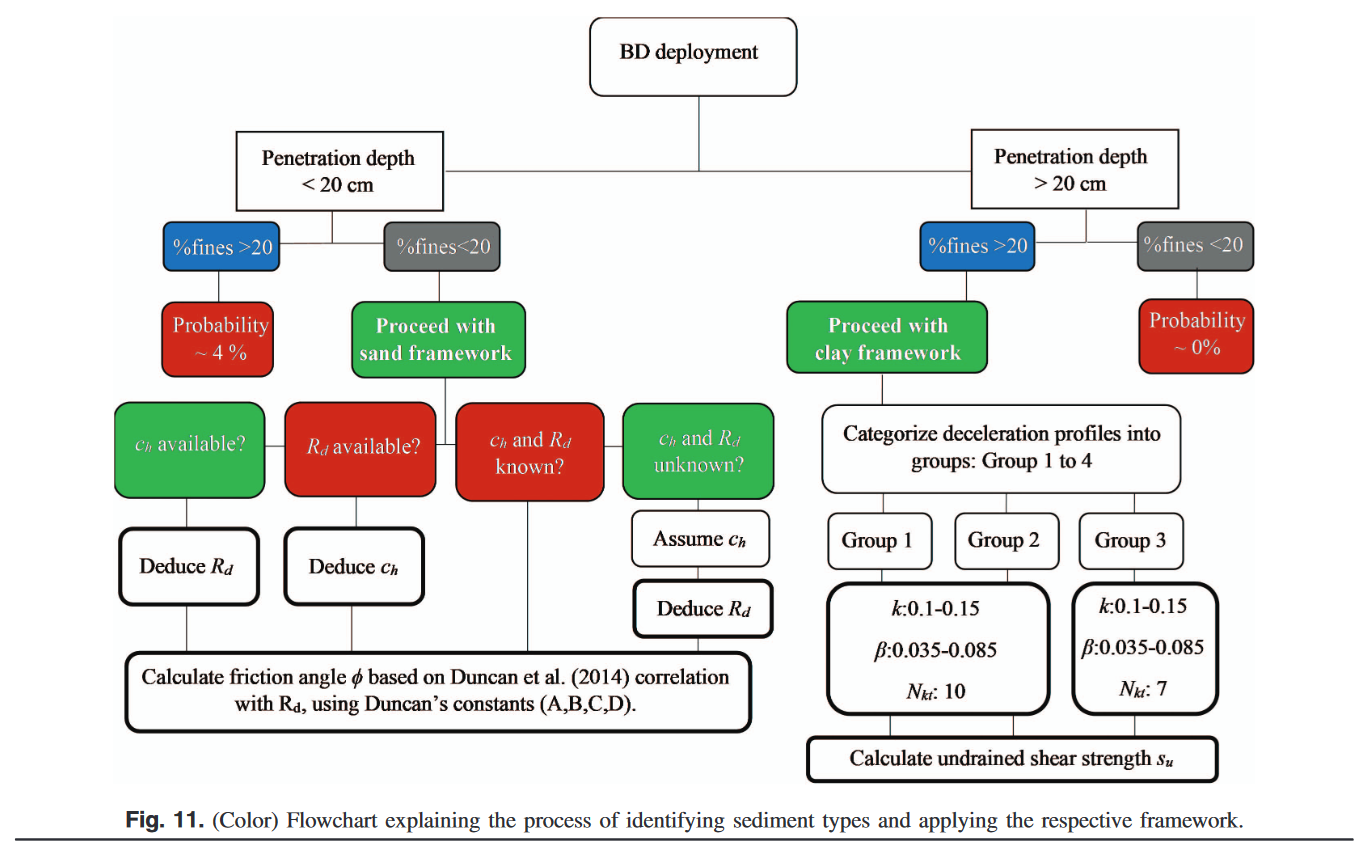